# Bitcoin Feature Engineering
In this notebook we take the bitcoin data and create several new features for each date that include the evolution of closing price and volume during the previous year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data is obtained from the following URL, using the download option in the web page: https://finance.yahoo.com/quote/BTC-USD/history?period1=1451606400&period2=1632614400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [3]:
#we are loading the data from 01/01/2015 to 26/09/2021
btc_hist = pd.read_csv('./data_orig/BTC-USD.csv')

In [4]:
#There are some missing values

btc_hist[btc_hist.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1933,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
2108,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
2111,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
2112,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#We add the missing data manually (these values come from coinmarketcap.com)
#then we create a copy of the data so as not to change the original

btc_hist_m=btc_hist.copy()

btc_hist_m.loc[[2112]]=['2020-10-13', 11548.72, 11548.98, 11321.22,
        11425.90, 11425.90, 24241420251.0]
btc_hist_m.loc[[2111]]=['2020-10-12', 11392.64, 11698.47, 11240.69,
        11555.36, 11555.36, 26163972642.0]
btc_hist_m.loc[[2108]]=['2020-10-09', 10927.91, 11102.67, 10846.85,
        11064.46, 11064.46, 22799117613.0]
btc_hist_m.loc[[1933]]=['2020-04-17', 7116.55, 7167.18, 7050.33,
        7096.18, 7096.18, 32513423567.0]

btc_hist_m[btc_hist_m.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [6]:
#We change the column Date to a date format
btc_hist_m['Date']=pd.to_datetime(arg=btc_hist_m['Date'],format='%Y-%m-%d')

In [7]:
#Erasing unnecesary columns
btc_hist_m = btc_hist_m.drop(labels=['Open','High','Low','Adj Close'], axis=1)

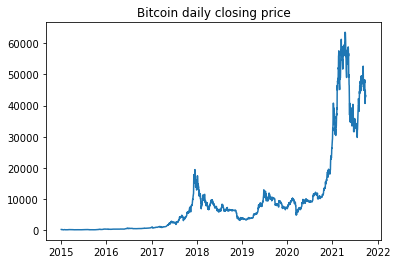

In [10]:
#Let's take a look at the data
plt.plot(btc_hist_m['Date'], btc_hist_m['Close'])
plt.title("Bitcoin daily closing price")
plt.show()

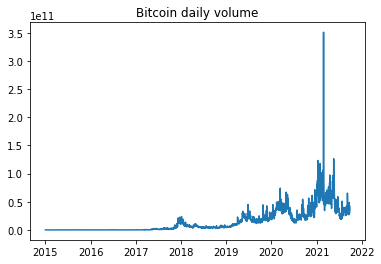

In [11]:
#Let's take a look at the data
plt.plot(btc_hist_m['Date'], btc_hist_m['Volume'])
plt.title("Bitcoin daily volume")
plt.show()

In [12]:
# We create new columns for days and months
btc_hist_m['dia']=btc_hist_m['Date'].dt.day_name()
btc_hist_m['mes']=btc_hist_m['Date'].dt.month

In [13]:
#Here, we are adding columns with variations from previous day, week and month
btc_hist_m['C_dia_ant'] = btc_hist_m['Close'].shift(1)
btc_hist_m['C_dia_ant'].loc[[0]]=btc_hist_m['C_dia_ant'][1]

btc_hist_m['var_dia_ant']=btc_hist_m['Close']/btc_hist_m['C_dia_ant']-1

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
btc_hist_m['C_sem_ant'] = btc_hist_m['Close'].shift(7)

for i in range(0,7):
    btc_hist_m['C_sem_ant'].loc[[i]]=btc_hist_m['C_sem_ant'][i+7]

btc_hist_m['var_sem_ant']=btc_hist_m['Close']/btc_hist_m['C_sem_ant']-1

In [15]:
btc_hist_m['C_mes_ant'] = btc_hist_m['Close'].shift(30)

for i in range(0,30):
    btc_hist_m['C_mes_ant'].loc[[i]]=btc_hist_m['C_mes_ant'][i+30]

btc_hist_m['var_mes_ant']=btc_hist_m['Close']/btc_hist_m['C_mes_ant']-1

In [16]:
#There seem to be important differences between weekdays (on mondays prices go up much more than on sundays)
btc_hist_m.groupby('dia')['var_dia_ant'].mean()

dia
Friday       0.004046
Monday       0.006154
Saturday     0.003444
Sunday       0.000011
Thursday     0.002681
Tuesday      0.000859
Wednesday    0.002302
Name: var_dia_ant, dtype: float64

In [17]:
#Let's see if there's a significant difference in the number of times prices go up for each weekday
#The "best" days change with respect to the ones with the biggest variations, but there are important differences
#In this case, the probability of price going up on a Saturday is 6,5% higher than on a Tuesday
btc_hist_m.groupby('dia')['var_dia_ant'].apply(lambda x: (x>0).sum()/(x).count())*100

dia
Friday       58.238636
Monday       54.985755
Saturday     57.954545
Sunday       51.704545
Thursday     53.977273
Tuesday      51.566952
Wednesday    54.415954
Name: var_dia_ant, dtype: float64

In [18]:
#There seem to be important differences between months,
#but we can't say that's representative because we have very few months of each (6 years)
btc_hist_m[btc_hist_m['Date']<'2021-01-01'].groupby('mes')['var_mes_ant'].mean()

mes
1     0.015642
2     0.005357
3     0.004432
4     0.055069
5     0.231284
6     0.153740
7     0.070115
8     0.079969
9    -0.017804
10    0.083951
11    0.190223
12    0.210622
Name: var_mes_ant, dtype: float64

In [19]:
#Adding column for variation in volume from previous day
btc_hist_m['V_dia_ant'] = btc_hist_m['Volume'].shift(1)
btc_hist_m['V_dia_ant'].loc[[0]]=btc_hist_m['V_dia_ant'][1]

btc_hist_m['var_V_dia_ant']=btc_hist_m['Volume']/btc_hist_m['V_dia_ant']-1

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


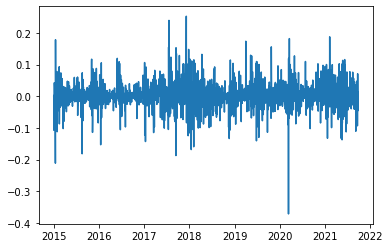

In [20]:
#Let's take a look at the variation data for prices
#I think everything outside the variation range [-0.15,0.15] is an outlier
plt.plot(btc_hist_m['Date'], btc_hist_m['var_dia_ant'])

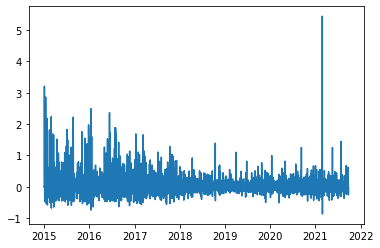

In [21]:
#Let's take a look at the variation data for volume
#I'm pretty sure everything over 200% variation is an outlier
plt.plot(btc_hist_m['Date'], btc_hist_m['var_V_dia_ant'])

In [22]:

#We create the real dataset for classification algorithms. It will contain:
#day-to-day price variation of the last 30 days
#day-to-day volume variation of the last 30 days
#week-to-week price variation from 4 weeks before to 12 weeks before
#month-to-month price variation from 3 months before to 11 months before
#the day of the week
#if the price variation of the following day is considered an outlier (1) or not (0)
#if the price went up (1) o not (0) the next day. This is what we are trying to predict
#the variation in price that actually occurred the next day
#all this data starting 2016/1/1

columnasData=['varP0', 'varP1', 'varP2', 'varP3', 'varP4', 'varP5', 'varP6', 'varP7', 'varP8', 'varP9',
             'varP10', 'varP11', 'varP12', 'varP13', 'varP14', 'varP15', 'varP16', 'varP17', 'varP18', 'varP19',
             'varP20', 'varP21', 'varP22', 'varP23', 'varP24', 'varP25', 'varP26', 'varP27', 'varP28', 'varP29',
             'varPs30', 'varPs37', 'varPs44', 'varPs51', 'varPs58', 'varPs65', 'varPs72', 'varPs79', 'varPs86',
             'varPm93', 'varPm123', 'varPm153', 'varPm183', 'varPm213', 'varPm243', 'varPm273', 'varPm303',
             'varPm333',
             'varV0', 'varV1', 'varV2', 'varV3', 'varV4', 'varV5', 'varV6', 'varV7', 'varV8', 'varV9',
             'varV10', 'varV11', 'varV12', 'varV13', 'varV14', 'varV15', 'varV16', 'varV17', 'varV18', 'varV19',
             'varV20', 'varV21', 'varV22', 'varV23', 'varV24', 'varV25', 'varV26', 'varV27', 'varV28', 'varV29',
             'dia', 'outlier', 'subida','varPSig']
data_for_use = pd.DataFrame(columns=columnasData)


for i in range(0,btc_hist_m.shape[0]-1):
    if btc_hist_m['Date'][i]>pd.to_datetime(arg='2015-12-31',format='%Y-%m-%d'):
        dtemp = pd.concat([pd.DataFrame(btc_hist_m['var_dia_ant'][i-29:i+1][::-1].values),
                            pd.DataFrame(btc_hist_m['var_sem_ant'][i-92:i-29][::-7].values),
                            pd.DataFrame(btc_hist_m['var_mes_ant'][i-362:i-92][::-30].values),
                            pd.DataFrame(btc_hist_m['var_V_dia_ant'][i-29:i+1][::-1].values),
                            pd.DataFrame([btc_hist_m['dia'][i]]),
                            pd.DataFrame([abs(btc_hist_m['var_dia_ant'][i+1])>0.15]),
                            pd.DataFrame([btc_hist_m['var_dia_ant'][i+1]>0]),
                            pd.DataFrame([btc_hist_m['var_dia_ant'][i+1]])],
                          ignore_index=True, axis=0).T

        dtemp = dtemp.set_index(keys=[btc_hist_m['Date'].loc[[i]]])
        
        new_cols = {x: y for x, y in zip(dtemp.columns, data_for_use.columns)}

        dtemp = dtemp.rename(columns=new_cols)

        data_for_use = data_for_use.append(dtemp.rename(columns=new_cols))


In [23]:
data_for_use.head(20)

,varP0,varP1,varP2,varP3,varP4,varP5,varP6,varP7,varP8,varP9,...,varV24,varV25,varV26,varV27,varV28,varV29,dia,outlier,subida,varPSig
2016-01-01,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,0.0132982,-0.0842286,0.00146825,0.0284447,0.0133518,...,-0.0891077,-0.183974,0.173196,0.852281,-0.294407,-0.0636183,Friday,False,False,-0.00206299
2016-01-02,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,0.0132982,-0.0842286,0.00146825,0.0284447,...,0.572924,-0.0891077,-0.183974,0.173196,0.852281,-0.294407,Saturday,False,False,-0.00790656
2016-01-03,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,0.0132982,-0.0842286,0.00146825,...,-0.426523,0.572924,-0.0891077,-0.183974,0.173196,0.852281,Sunday,False,True,0.00716265
2016-01-04,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,0.0132982,-0.0842286,...,1.12785,-0.426523,0.572924,-0.0891077,-0.183974,0.173196,Monday,False,False,-0.00261149
2016-01-05,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,0.0132982,...,0.18951,1.12785,-0.426523,0.572924,-0.0891077,-0.183974,Tuesday,False,False,-0.00660936
2016-01-06,-0.00660936,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,-0.0012866,...,-0.582852,0.18951,1.12785,-0.426523,0.572924,-0.0891077,Wednesday,False,True,0.0674497
2016-01-07,0.0674497,-0.00660936,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,0.0253482,...,1.37047,-0.582852,0.18951,1.12785,-0.426523,0.572924,Thursday,False,False,-0.0105185
2016-01-08,-0.0105185,0.0674497,-0.00660936,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,-0.0146957,...,-0.363037,1.37047,-0.582852,0.18951,1.12785,-0.426523,Friday,False,False,-0.0123977
2016-01-09,-0.0123977,-0.0105185,0.0674497,-0.00660936,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,0.00925177,...,0.298635,-0.363037,1.37047,-0.582852,0.18951,1.12785,Saturday,False,True,0.000848963
2016-01-10,0.000848963,-0.0123977,-0.0105185,0.0674497,-0.00660936,-0.00261149,0.00716265,-0.00790656,-0.00206299,0.008749,...,-0.555525,0.298635,-0.363037,1.37047,-0.582852,0.18951,Sunday,False,True,0.000975493


In [24]:
# We store the engineered data in a new file
data_for_use.to_csv('./data_proc/bitcoin_data_for_use.csv')